In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
class Model:
    """2-box model to study global CH4 cycle with simple data assimilation.
    TO DO NEXT:
    - MAKE IT POSSIBLE TO HANDLE OBSERVATIONS OF SELF.CONC[1]
    - READ OBS IN EXTERNAL FILE
    - SIMPLIFY MANAGEMENT OF TIME: self.time vs day...
    """
    
    def __init__(self, nmembers=1):
        self.nmembers = nmembers
        self.conc = np.ones((2,self.nmembers))*20000.
        self.dt = 1.                   # in days
        self.time = 0.
        self.kflux = 1./(1.5*365)      # interhemisphere transport time
        self.loss = 1./(10.*365)       # life time 10 years
        self.conc_series = []
        self.time_series = []
        self.variability=[]
        
        # Baseline emission and transport rates
        self.base_Emissions  = np.outer( np.array([10.,1.]), np.ones(self.nmembers) )  # emissions 
        self.both_Hemisphere = np.outer( np.array([1.,-1.]), np.ones(self.nmembers) )  # transport directions
        self.transport_param = np.outer( np.array([0.2,0.1]), np.ones(self.nmembers) ) # transport rates
        
        # add seasonal variability of emissions (opposite phases in noth hemispheres)
        self.factor_variability=0.5     
        self.variability= np.sin(2*np.pi*np.arange(0,365)/365.)*self.factor_variability*np.array([[1.],[-1.]])
        self.variability = self.variability[:,:,np.newaxis]        # This is for ensembles

        # For nudging. Those parameters are prescribed at call of run function.
        self.k_nudging = 0.
        self.day_interval = 0
        
        # To compute MSE
        self.mse = np.zeros(self.nmembers)
        
        # For ensembles. Perturb emission amplitudes and inter-hemispheric transport rates.
        if self.nmembers > 1: 
            zero2 = np.zeros(2)
            iden2 = np.eye(2)
            self.base_Emissions += 1.5 * np.transpose(np.random.multivariate_normal(zero2,iden2,self.nmembers))
            self.transport_param += 0.02 * np.transpose(np.random.multivariate_normal(zero2,iden2,self.nmembers))
            
    def initialize(self, xc, day=0):
        """reinitialize model. xc here is a 2-entry array."""
        for ie in range(self.nmembers):
            self.conc[:,ie] = xc
        self.time = day
        self.conc_series = []
        self.time_series = []
        
    def rungekutta(self, func_in):
        """update concentration with a Runge-Kutta 4 step.
        func_in is the RHS term of the equation. func_in only takes a conc array as argument."""
        k1 = func_in(self.conc) * self.dt
        xtmp = self.conc + 0.5 * k1
        k2 = func_in(xtmp) * self.dt
        xtmp = self.conc + 0.5 * k2
        k3 = func_in(xtmp) * self.dt
        xtmp = self.conc + k2
        k4 = func_in(xtmp) * self.dt
        self.conc += (k1+2*k2+2*k3+k4)/6.
        
    def rhs(self, xc):
        """Compute the right-hand-side term of the 2-box differential equation."""
        rhs_out = np.empty_like(xc)
        flux1 = -self.kflux*xc[0,] + self.kflux*xc[1,]
        # Emissions are base emissions + seasonal variability (based on the day )
        day = int(self.time)
        Emissions = self.base_Emissions * (1 + self.variability[:,day%365,] )       
        rhs_out = Emissions - self.loss*xc + flux1*self.both_Hemisphere*self.transport_param
        return rhs_out
    
    def nudging_coefficient(self, day, obsday):
        """Compute the nudging coefficient K. K is a hat function taking values
        0 at day = obsday - or + day_interval, and self.k_nudging at day = obsday.
        ----------
        Parameters:
        ----------
        day: simulation day (integer of self.time)
        obs_day: day of observation
        -------
        Returns:
        -------
        nudging coefficient. 
        """
        a = obsday-day
        a = 1. - np.sign(a)*a/float(self.day_interval)
        a = np.maximum(a,0.)
        return self.k_nudging*a

    def nudging_term(self, xc):
        """Compute the nudging term using all eligible observations.
        IMPORTANT: AS TO NOW, IT IS HARDCODED THAT INDEX 0 OF SELF.CONC IS OBSERVED. THIS MUST BE IMPROVED."""
        nudg_out = np.zeros_like(xc)
        day = int(self.time)
        check_obs, obs_days, obs_values = self.observation(day)      # get obs. days and values for the day
        if check_obs == True:
            nobs = len(obs_days)
            for io in range(nobs):
                obsday = obs_days[io]
                obsval = obs_values[io]
                nudg_out[0,] += self.nudging_coefficient(day, obsday)*(obsval-self.conc[0,])           
        return nudg_out
        
    def rhs_with_nudging(self, xc):
        """return RHS term expanded with nudging term. This is meant to be argument of the rungekutta function."""
        return self.rhs(xc) + self.nudging_term(xc)
    

    def run(self, days, mode='free', method='nudging', k_nudging=0.2, day_interval=20):
        """Run the model time integration, with or without data assimilation.
        ----------
        Parameters:
        ----------
        days: number of days of integration
        mode: 'free' (default) or 'assim'.
        method: assimilation method. 'substitution' or 'nudging' (default)
        k_nudging: nudging coefficient. Default: 0.2
        day_interval: time lag around observation time, over which nudging is applied. Default: 20
        -------
        Returns:
        -------
        no explicit outputs. Changes class attributes conc, conc_series, time, time_series
        """
        nsteps = int(days/self.dt)     
        _conc_series = np.zeros((2, nsteps+1, self.nmembers))
        _conc_series[:,0,:] = self.conc
        _time_series = np.empty(nsteps+1)
        _time_series[0] = self.time
        
        if mode == 'free':
            nobs = 0
            for it in range(nsteps):
            #for ie in range(self.nmembers):
                self.time += self.dt
                self.rungekutta(self.rhs)
                _conc_series[:,it+1,:] = self.conc
                _time_series[it+1] = self.time
                day = int(self.time)
                check_obs, obs_days, obs_values = self.observation(day)
                if check_obs == True:
                    nobs += 1
                    self.mse += ( self.conc[0,] - obs_values[0] )**2
            if nobs != 0:
                self.mse /= nobs
                self.mse = np.sqrt(self.mse)
            
        if mode == 'assim' and method == 'substitution':
            for it in range(nsteps):
            #for ie in range(self.nmembers):
                self.time += self.dt
                self.rungekutta(self.rhs)
                day = int(self.time)
                check_obs, obs_days, obs_values = self.observation(day)
                if check_obs == True:
                    self.conc[0,] = obs_values[0]
                _conc_series[:,it+1,:] = self.conc
                _time_series[it+1] = self.time
            
        if mode == 'assim' and method == 'nudging':
            self.k_nudging = k_nudging
            self.day_interval = day_interval
            for it in range(nsteps):
                self.time += self.dt
                self.rungekutta(self.rhs_with_nudging)
                _conc_series[:,it+1,:] = self.conc
                _time_series[it+1] = self.time

        if len(self.time_series) == 0:            # check empty list
            self.time_series = _time_series
            self.conc_series = _conc_series
        else:
            self.time_series = np.hstack((self.time_series, _time_series))
            self.conc_series = np.hstack((self.conc_series, _conc_series))
    
    def read_obs(self):
        day_list = [200, 400, 600, 800]
        obs_val = [21850, 21400, 21745, 21520]
        return day_list, obs_val
    
    
    def observation(self, day):
        """Check if an obs is available for this day and get value.
        In future designs, the first two arrays should be read externally."""
        day_list, obs_val = self.read_obs()
        check = False
        obsday = []
        obsval = []
        for day_tmp in day_list:
            if day in range(day_tmp-self.day_interval, day_tmp+self.day_interval+1):
                check = True
                obsday = obsday + [day_tmp]
                io = day_list.index(day_tmp)
                obsval = obsval + [obs_val[io]]   
        return check, obsday, obsval
                
    def plot_series(self):
        x, y = self.read_obs()

        plt.figure(figsize=(12,4))
        for ie in range(self.nmembers):
            ax1 = plt.subplot(1,2,1)
            ax1.plot(self.time_series,self.conc_series[0,:,ie],'black',linewidth=1.)
            ax1.plot(x,y,'bo')
            ax1.set_title('North')
            ax1.set_xlabel('time (days)')
            ax1.set_ylabel('Concentration')
            ax2 = plt.subplot(1,2,2)
            ax2.plot(self.time_series,self.conc_series[1,:,ie],'red',linewidth=1.)
            ax2.set_title('South')
            ax2.set_xlabel('time (days)')
            ax2.set_ylabel('Concentration')
        plt.show()

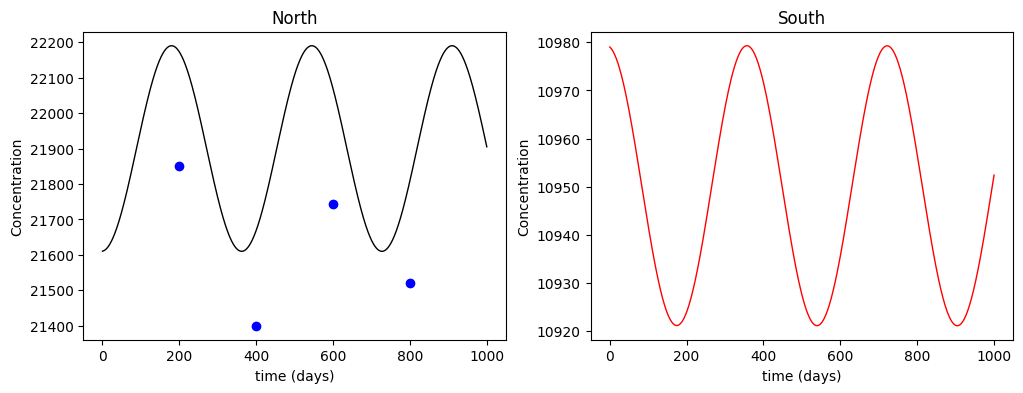

In [5]:
spinup = Model()
spinup.run(365*100)
conc_init = spinup.conc[:,0]
\
toto = Model()
toto.initialize(conc_init, day=0.)
toto.run(1000)
toto.plot_series()

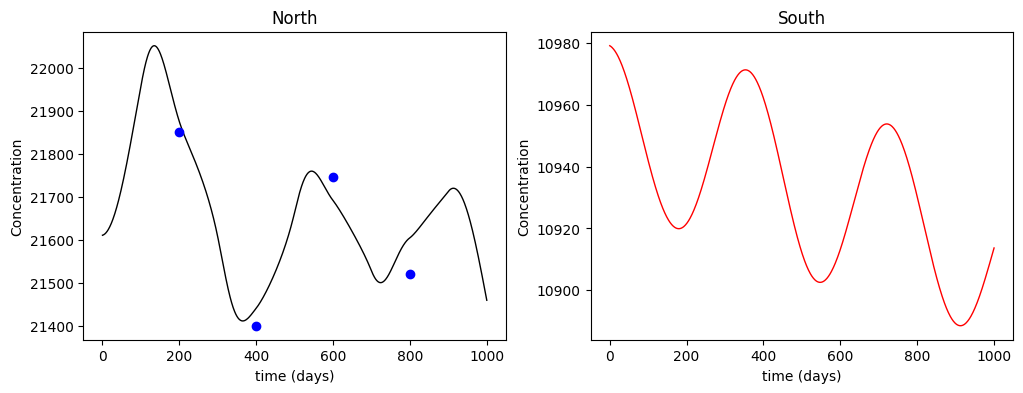

In [11]:
titi = Model()
titi.initialize(conc_init, day=0.)
titi.run(1000, mode='assim', method='nudging', k_nudging = 0.05, day_interval = 100)
titi.plot_series()